In [28]:
from keras.datasets import mnist
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Hyper parameters

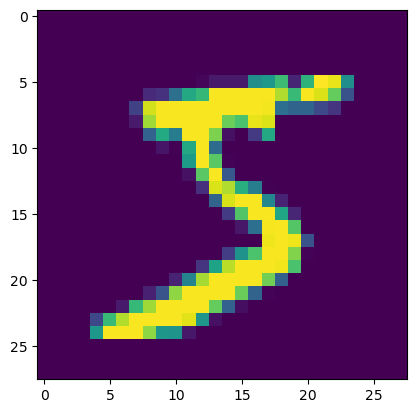

(60000, 784) (60000, 10)


In [29]:
(x_train,y_train), (x_test, y_test) = mnist.load_data()
n_outputs = len(np.unique(y_train))
image_size = x_train.shape[1]

plt.imshow(x_train[0])
plt.show()

x_train = x_train.reshape((-1, image_size * image_size)).astype('float32')/255
x_test = x_test.reshape((-1, image_size * image_size)).astype('float32')/255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

hidden_layers = [256, 256]
n_inputs = image_size * image_size
n_epochs = 10
batch_size = 32
m_train = x_train.shape[0]
print(x_train.shape, y_train.shape)

In [30]:
tf.compat.v1.disable_eager_execution()
with tf.name_scope('placeholders'):
    x_p = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, n_inputs], name='x_p')
    y_p = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, n_outputs], name='y_p')
    keep_prob_p = tf.compat.v1.placeholder(dtype=tf.float32, name='keep_prop')

In [31]:
with tf.name_scope('hidden_layer_1'):
    weight_1 = tf.compat.v1.Variable(
        tf.compat.v1.random_normal(stddev=0.01, shape=(n_inputs, hidden_layers[0])),
        dtype=tf.float32, name='w_1')
    bias_1 = tf.compat.v1.Variable(
        tf.compat.v1.random_normal(stddev=0.01, shape=(hidden_layers[0],)),
        dtype=tf.float32, name='b_1')
    hidden_layer_1 = tf.nn.relu(tf.matmul(x_p,weight_1) + bias_1)
    hidden_layer_1 = tf.compat.v1.nn.dropout(hidden_layer_1, keep_prob=keep_prob_p)

In [32]:
with tf.name_scope('hidden_layer_2'):
    weight_2 = tf.compat.v1.Variable(
        tf.compat.v1.random_normal(stddev=0.01, shape=(hidden_layers[0], hidden_layers[1])),
        dtype=tf.float32, name='w_2')
    bias_2 = tf.compat.v1.Variable(
        tf.compat.v1.random_normal(stddev=0.01, shape=(hidden_layers[1],)),
        dtype=tf.float32, name='b_2')
    hidden_layer_2 = tf.nn.relu(tf.matmul(hidden_layer_1,weight_2) + bias_2)
    hidden_layer_2 = tf.compat.v1.nn.dropout(hidden_layer_2, keep_prob=keep_prob_p)

In [33]:
with tf.name_scope('ouput_layer'):
    weight_output = tf.compat.v1.Variable(
        tf.compat.v1.random_normal(stddev=0.01, shape=(hidden_layers[-1], n_outputs)),
        dtype=tf.float32, name='w_outputs')
    bias_output = tf.compat.v1.Variable(
        tf.compat.v1.random_normal(stddev=0.01, shape=(n_outputs,)),
        dtype=tf.float32, name='b_outputs')
    logits = tf.matmul(hidden_layer_2, weight_output) + bias_output
    y_predict_t = tf.nn.softmax(logits)

In [34]:
with tf.name_scope('accuracy'):
    equallity_check = tf.equal(tf.argmax(y_predict_t, axis=1), tf.argmax(y_p, axis=1))
    accuracy_op = tf.reduce_mean(tf.cast(equallity_check, tf.float32))


In [35]:
with tf.name_scope('loss'):
    entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_p)
    loss_op = tf.reduce_mean(entropy)

In [36]:
with tf.name_scope('optimizer'):
    optimizer = tf.compat.v1.train.AdamOptimizer().minimize(loss_op)

In [37]:
with tf.name_scope('summary'):
    tf.summary.scalar('loss', loss_op)
    merged = tf.compat.v1.summary.merge_all()
train_writer = tf.compat.v1.summary.FileWriter('./tf_logs', tf.compat.v1.get_default_graph())

In [ ]:
init = tf.compat.v1.global_variables_initializer()
with tf.compat.v1.Session() as sess:
    sess.run(init)
    step = 1
    for epoch in range(1 , n_epochs + 1):
        pos = 0
        while pos < m_train:
            x_batch = x_train[pos: pos + batch_size]
            y_batch = y_train[pos: pos + batch_size]

            feed_dict = {x_p: x_batch, y_p: y_batch, keep_prob_p:0.5}
            summary, _ = sess.run([merged, optimizer], feed_dict=feed_dict)
            train_writer.add_summary(summary, step)

#             print(f'epoch: {epoch}, step:{step}, loss_value: {loss_value}')

            step += 1
            pos += batch_size
        y_predict = sess.run(y_predict_t, feed_dict={x_p: x_test, keep_prob_p:1})
        acc = accuracy_score(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_predict, axis=1))
        accuracy_value,loss_value = sess.run([accuracy_op,loss_op], feed_dict={x_p: x_test, y_p:y_test, keep_prob_p:1})
        print(f'test accuracy(tensor): {accuracy_value}')
        print(f'test accuracy: {acc}, loss value: {loss_value}')

